In [1]:
import os 
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import seaborn as sns, matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.stats import sem
from scipy import stats
from scipy.signal import chirp, find_peaks, peak_widths, butter
import statannot
from statannot import add_stat_annotation
import statsmodels.api as sm
import netneurotools
from netneurotools import stats as st
import math
import string

%matplotlib inline  

C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [39]:
# some functions
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def percentage(part, whole):
    return 100 * float(part)/float(whole)

def fisher_transform(correlation_values):
    # Convert correlation values to z-scores using Fisher transformation
    valid_values = np.array(correlation_values)
    valid_values = valid_values[~np.isnan(valid_values)]  # Remove NaN values
    
    adjusted_values = np.where(valid_values == -1, valid_values + 1e-8, valid_values)  # Adjust -1 to avoid arithmetic error
    z_scores = np.arctanh(adjusted_values)
    
    return z_scores

## Process PEEG_TVNS data

#### To run processing: prepPupil(sub).process()
##### - sub = subject number (i.e. '001')
#### Can change following variables under __init__:
##### - peeg_path = path where the data is stored
##### - start_window = start time of event (i.e. -10 for 10s before start of trial)
##### - end_window = end time of event (i.e. 15 for 15s after start of trial)
##### - sF = sample freq of pupil data
##### - invalid_threshold = % of invalid samples in trial
##### - save_dir_name = where to save processed pupil data
##### - save_data = to save or not to save
##### - apply_gaze_correction = True/False (removes sampled where gaze (x or y) is >3SD away from mean (centre of screen))


#### To replicate Sharon: 
##### - length timecourse: –10 s to 13.4 s
##### - invalid threshold (max % intropelated data per trial): 50% 
##### - use % pupil change instead of pupil size [(x – baseline/baseline) * 100]
##### - baseline: 10 s
##### - for visualization: single-participant timcourse bandpass filtered between 0.01 and 10 Hz
##### - individual plot for visualisation: -3.2 s to 10.4 s

#### Other considerations: 
##### - Duration of baseline pupil size 
##### - Checking for gaze (how?) - load in gaza data, where pps look away from centre of screen > set threshold - enter NaNs in pupil size timeseries
##### - Checking for gender differences
##### - Effects of time of day (baseline levels change throughout the day)


In [2]:
class prepPupil(object):
    ''' To run prepPupil(sub).process()
    
    does the following:
    - makes a trial_onset file for each run inside pupil preprocess folder (can use in GUI to click through trials)
    - applies invalid sample threshold to each trial (can set this in __init__) throws out trials that cross this threshold (Sharon = 50%) 
    - saves event pupil timecourse (can set start/end duration in __init__) for each sub per run as .csv file(average of remaining trials in run)
    - saves group file with the following information + more: 
        sub; 
        ave_baseline_stim; 
        ave_baseline_sham; 
        no_trial_remain_stim; 
        no_trial_remain_sham; 
        age; 
        fin_intensity_stim; 
        fin_intensity_sham; 
        subj_rat_stim_q1 - q11;
        subj_rat_sham_q1 - q11;
        
    '''
    
    
    def __init__(self, sub):
        self.peeg_path = 'C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS'   # change this path 
        self.sub = sub
        self.sF = 40
        self.set_invalid_threshold = 50.0
        self.start_window_beforeE = 10
        self.start_window_afterE = 0.05
        self.end_window = 13.4
        self.save_dir_name ='/processed_data/pupil'
        self.save_data = True
        self.start_BF_ave_window = 2.88
        self.end_BF_ave_window = 5.96
        self.start_Wind_after = False
        self.apply_gaze_correction = False   # only apply one of these at a time- will be seperately checked for the paper
        self.apply_blink_correction = False
        
    def get_dat(self):
        peeg_tvns_dat = {'sm_pup_dat': glob.glob('{}/raw_data/tobii_data/PEEG_EEG{}/PupCor_output/run*TOBII_output_expdata_smth_int_pup.txt'.format(self.peeg_path,self.sub)),
                         'markers': glob.glob('{}/raw_data/tobii_data/PEEG_EEG{}/run*_TOBII_output_markers.tsv'.format(self.peeg_path,self.sub)),
                         'raw_pup_dat':glob.glob('{}/raw_data/tobii_data/PEEG_EEG{}/PupCor_output/run*TOBII_output_expdata_raw_pup_Right.txt'.format(self.peeg_path,self.sub)),
                         'tsv_pup':glob.glob('{}/raw_data/tobii_data/PEEG_EEG{}/run*TOBII_output_expdata.tsv'.format(self.peeg_path,self.sub)),
                         'behav_dat': glob.glob('{}/raw_data/data/PEEG_EEG{}/run*_PEEG_task_*.xpd'.format(self.peeg_path,self.sub)),
                         'blink_dat': '{}/processed_data/other_data/blink_rate.txt'.format(self.peeg_path),
                         'sub_artefact_corr': ['006', '008', '011', '012', '013', '016', '020', '024', '025', '027', '029', '030', '031', '032', '036', '039'],
                         'file_artefact_corr': '{}/processed_data/other_data/sub_noArtefact.txt'.format(self.peeg_path)}
        
    #     if len(peeg_tvns_dat['sm_pup_dat']) == 0:
    #         print("No pupil data file found for sub {}".format(sub))
    #     if len(peeg_tvns_dat['behav_dat']) == 0:
    #         print("No behavioural data file found for sub {}".format(sub))
        #print("No. of tobii data file found for sub {} is {}".format(self.sub, len(peeg_tvns_dat['sm_pup_dat'])))
        #print("No. of behavioural data file found for sub {} is {}".format(self.sub, len(peeg_tvns_dat['behav_dat'])))
        return peeg_tvns_dat

        
    def make_empty_array(self):
        #empty_array = np.array(list(range(1,int((time_end-time_start)*sF)+1)))
        if self.start_Wind_after:
            empty_array = np.empty((1,int((self.end_window)*self.sF)))  # no period back in time
        else:
            empty_array = np.empty((1,int((self.end_window--self.start_window_beforeE)*self.sF)))
        empty_array[:] = np.NaN # make array list 
        empty_array=np.array(empty_array).ravel() # unravel
        return empty_array

    
    def get_no_artefact_trials(self): #gets the trials which didn't have stimulation! 
        dat=self.get_dat()
        artefact_trials = pd.read_csv(dat['file_artefact_corr'], header=0, index_col=0, sep='\t', dtype={"sub":"string", "noArtefact":"string"})
        non_regular_subs = ['018']   # subjects who's trials counter for eeg is off-> need to do some manual work depending on timings 
        #noArtefact_trials = artefact_trials[artefact_trials['sub']==self.sub]['noArtefact'].astype("string")
        noArtefact_trials = artefact_trials.loc[self.sub]['noArtefact']
        a_list = noArtefact_trials.split()
        map_object = map(int, a_list)
        noArtefact_trials = list(map_object)

        return noArtefact_trials
        
    
#     # Remove samples +/1 3SD outside mean calculation
    def remove_spur_samples(self, event_timecourse, mean, sd):
        
        pup_list = np.array(event_timecourse).astype(np.float)
        pup_list.tolist()
        pup_list = [abs(number) for number in pup_list]
        temp_min=mean-sd
        temp_plus=mean+sd
        
        temp_timecourse=pup_list

        #check if the sample sits within min and max threshold 
        bool1=[val<temp_min for val in temp_timecourse]
        bool2=[val>temp_plus for val in temp_timecourse]
        bool3=np.logical_or(bool1, bool2)
        #new_timecourse = ['nan' if bool3[c]==True else val for c, val in enumerate(timecourse)] 
        return bool3
        
    def remove_blink_samples(self, event_timecourse):
        #check if the sample == -1.0000
        bool1=[int(x==-1.0000) for x in event_timecourse]
        #new_timecourse = ['nan' if bool3[c]==True else val for c, val in enumerate(timecourse)] 
        return bool1
        
        
    def get_subj_condition(self):
        cond_sham=[]
        cond_stim=[]

        if (self.sub == '003') or (self.sub == '035'):  # missing run 3 + 4
            cond_sham = [2]
            cond_stim = [1]
        elif self.sub == '008':   # only run 1 and 2 
            cond_sham = [1]
            cond_stim = [2]
        elif self.sub == '009': # excl run2 due to bad electrode position
            cond_sham = [1,3]
            cond_stim = [4]
        elif (self.sub == '019'): # opposite conditions
            cond_sham = [1,3]
            cond_stim = [2,4]
        elif (self.sub == '022'):  # opposite conditions
            cond_sham = [2,4]
            cond_stim = [1,3]
        elif (self.sub == '024'):  # opposite
            cond_sham = [2,4]
            cond_stim = [1,3]
        
        else:
            if (int(self.sub) % 2) == 0:   # even numbers sham then stim
                cond_sham = [1,3]
                cond_stim = [2,4]
            elif (int(self.sub) % 2) != 0:   # odd numbers stim then sham
                cond_sham = [2,4]
                cond_stim = [1,3]
        self.subj_condition = {'stim': cond_stim, 'sham':cond_sham}

        
    def load_run_events(self):
        # laod in the data
        dat=self.get_dat()
        # for appending the no. f excluded trials 
        total_remain_trials_stim = []
        total_remain_trials_sham = []
        ave_BL_stim = []
        ave_BL_sham = []
        pup_stim_dat = []
        pup_sham_dat = []
        pup_stim_dat_nocorr = []
        pup_sham_dat_nocorr = []
        SD_gaze_X_stim = []
        SD_gaze_X_sham = []
        SD_gaze_Y_stim = []
        SD_gaze_Y_sham = []
        stim_trial_m1s_BL = []
        sham_trial_m1s_BL = []
        halfMax_stim_wind = []
        halfMax_sham_wind = []
        pup_BL_block = []
        total_trial_counter = 0
        for run, (sm_pup_fn,  marker_fn, raw_pup_fn) in enumerate(zip(dat['sm_pup_dat'], dat['markers'], dat['raw_pup_dat'])):    
            trial_dat=self.make_empty_array() # get empty array length of event ready to fill
            trial_dat_nocorr=self.make_empty_array()
            gazeX_dat=self.make_empty_array() 
            gazeY_dat=self.make_empty_array()
            self.save_fn = os.path.join(f'{self.peeg_path}{self.save_dir_name}/PEEG_EEG{self.sub}/run{str(run+1)}_sub-{self.sub}_processed_pupil_timecourse.csv')   #eventually replace run with sham/stim

            #get data
            sm_pup=pd.read_csv(sm_pup_fn)
            makers=pd.read_csv(marker_fn, sep='\t')
            raw_pup=pd.read_csv(raw_pup_fn, header=None)
            tsvdat=pd.read_csv(dat['tsv_pup'][run], sep='\t') # need this for setting the correct starttime of pupil recording 
            
            # check if subject needs to be altered based on no artefact  (to be used below) 
            if self.sub in dat['sub_artefact_corr']:
                rem_noartefact_trials = self.get_no_artefact_trials()
            else: 
                rem_noartefact_trials=[] # no trials removed
            # Apply  low-pass filter using a 10Hzfourth-order Butterworth filter
            b, a = signal.butter(4, 10, 'lowpass', fs=40)   # check this with Franz!
            sm_pup = signal.filtfilt(b, a, sm_pup, padlen=0)

            # get the X and Y coord from the tsvdat file 
            gazeX_orig=tsvdat['GazePointXRight']
            gazeY_orig=tsvdat['GazePointYRight']
            
            # make nans out of all -1 values (invalid samaples)
            gazeX=['nan' if i == -1 else i for i in gazeX_orig]
            gazeY=['nan' if i == -1 else i for i in gazeY_orig]
            
            # get 3*SD pupil gaze in X and Y coord ---> use this as additional threshold for pupil size timeseries 
            gazeY_get_mean=np.array(gazeY).astype(np.float)
            meanY = np.nanmean(gazeY_get_mean)
            stdY_x_3 = (np.nanstd(gazeY_get_mean))*3
            
            gazeX_get_mean=np.array(gazeX).astype(np.float)
            meanX = np.nanmean(gazeX_get_mean)
            stdX_x_3 = (np.nanstd(gazeX_get_mean))*3
            
            # get the trial onset times
            trial_onset_orig=makers[makers['Marker'].str.contains("start_tVNS")]
            # account for the first timestamp of the tsv data 
            trial_onsets=trial_onset_orig['TimeStamp']-tsvdat['TimeStamp'][0]

            # get pupil sample number that starts at the trial onset
            sample_no_trial_onsets=[int((val/1000)*self.sF) for val in trial_onsets]

            # save as txt file (can use in GUI to click through trials)
            np.savetxt('{}/raw_data/tobii_data/PEEG_EEG{}/PupCor_output/run{}_trial_markers.txt'.format(self.peeg_path,self.sub, str(run+1)), sample_no_trial_onsets)

            run_invalidsample=[]
            nan_log_vec = ['NaN'] * len(sample_no_trial_onsets)  # to append for invalid trials 
            
            run_BL_total = []
            
            for index, tr_on in enumerate(sample_no_trial_onsets):
                total_trial_counter += 1  # make a total trial number to match with EEG no artefact selection 

                # Flag trials with >% of invalid samples 
                if self.start_Wind_after:
                    raw_pup_trial = raw_pup[tr_on:tr_on+int(self.end_window*self.sF)]
                else:
                    raw_pup_trial = raw_pup[tr_on-int(self.start_window_beforeE*self.sF):tr_on+int(self.end_window*self.sF)]

                interpol_vec=[int(x==-1.0000) for x in raw_pup_trial[0]]
                #print('no invalid samples in trial {} for run {} = {}'.format(index+1, run+1,sum(interpol_vec)))
                # get % of invalid samples in trial
                p_invalid_threshold = (sum(interpol_vec)/len(raw_pup_trial))*100
                run_invalidsample.append(p_invalid_threshold)
                
                # Create pre-trial baseline: -10s or +0.05ms
                if self.start_Wind_after:
                    preT_baseline =  np.mean(sm_pup[int(tr_on):int(tr_on)+int(self.start_window_afterE*self.sF)])
                    # save the pupil data for each event into array
                    pup_event_array = np.array(((sm_pup[tr_on:tr_on+int(self.end_window*self.sF)]-preT_baseline)/preT_baseline)*100)
                    #pup_event_array = np.array(sm_pup[tr_on:tr_on+int(self.end_window*self.sF)]-preT_baseline)  # --> subtraction analysis 
                else:
                    preT_baseline =  np.mean(sm_pup[int(tr_on)-int(self.start_window_beforeE*self.sF):int(tr_on)])
                    # save the pupil data for each event into array
                    pup_event_array = np.array(((sm_pup[tr_on-int(self.start_window_beforeE*self.sF):tr_on+int(self.end_window*self.sF)]-preT_baseline)/preT_baseline)*100)
                    #pup_event_array = np.array(sm_pup[tr_on-int(self.start_window_beforeE*self.sF):tr_on+int(self.end_window*self.sF)]-preT_baseline)  # --> subtraction analysis 
                    # save pupil event array no baseline correction
                    pup_event_array_nocorr = np.array(((sm_pup[tr_on-int(self.start_window_beforeE*self.sF):tr_on+int(self.end_window*self.sF)])))
                    # save the X and Y gaze points for the event
                    pup_gazeX_array = np.array(((gazeX[tr_on-int(self.start_window_beforeE*self.sF):tr_on+int(self.end_window*self.sF)])))
                    pup_gazeY_array = np.array(((gazeY[tr_on-int(self.start_window_beforeE*self.sF):tr_on+int(self.end_window*self.sF)])))                                    
            
                # save the pupil data for each event into array
                pup_event_array=np.squeeze(pup_event_array)
                pup_event_array_nocorr=np.squeeze(pup_event_array_nocorr)
                pup_gazeX_array=np.squeeze(pup_gazeX_array)
                pup_gazeY_array=np.squeeze(pup_gazeY_array)
            

                # additional thresholding based on pupil gaze: if gaze sample (x or y) falls >3sd away from mean of whole timeseries for run --> make nan
                if self.apply_gaze_correction:
                    # remove spur gaze samps X + Y coord
                    # X
                    to_remX = self.remove_spur_samples(pup_gazeX_array, meanX, stdX_x_3)
                    pup_event_array = np.array(['nan' if to_remX[c]==True else val for c, val in enumerate(pup_event_array)])
                    pup_event_array_nocorr = np.array(['nan' if to_remX[c]==True else val for c, val in enumerate(pup_event_array_nocorr)])
                    # Y
                    to_remY = self.remove_spur_samples(pup_gazeY_array, meanY, stdY_x_3)
                    pup_event_array = np.array(['nan' if to_remY[c]==True else val for c, val in enumerate(pup_event_array)])
                    pup_event_array_nocorr = np.array(['nan' if to_remY[c]==True else val for c, val in enumerate(pup_event_array_nocorr)])
                elif self.apply_blink_correction:
                    # remove blink samples (instead of interopolating)
                    to_remBlink = self.remove_blink_samples(raw_pup_trial[0])
                    pup_event_array = np.array(['nan' if to_remBlink[c]==True else val for c, val in enumerate(pup_event_array)])
                    pup_event_array_nocorr = np.array(['nan' if to_remBlink[c]==True else val for c, val in enumerate(pup_event_array_nocorr)])
                    
                nan_array = self.make_empty_array() # create nan array:
                

                if (self.sub in dat['sub_artefact_corr']) & (total_trial_counter in rem_noartefact_trials):  # no stimulation happened
                    trial_dat = np.vstack([trial_dat,nan_array])
                    trial_dat_nocorr = np.vstack([trial_dat_nocorr,nan_array])
                    gazeX_dat = np.vstack([gazeX_dat,nan_array])
                    gazeY_dat = np.vstack([gazeY_dat,nan_array])
                    run_BL_total.append('NaN')  # save nan as baseline
                    
                # save pupil data / nan array depending on threshold
                elif p_invalid_threshold > self.set_invalid_threshold:
                    trial_dat = np.vstack([trial_dat,nan_array])
                    trial_dat_nocorr = np.vstack([trial_dat_nocorr,nan_array])
                    gazeX_dat = np.vstack([gazeX_dat,nan_array])
                    gazeY_dat = np.vstack([gazeY_dat,nan_array])
                    run_BL_total.append('NaN')  # save nan as baseline
                    
                else:
                    trial_dat = np.vstack([trial_dat, pup_event_array])     
                    trial_dat_nocorr = np.vstack([trial_dat_nocorr, pup_event_array_nocorr])      
                    gazeX_dat = np.vstack([gazeX_dat, pup_gazeX_array])
                    gazeY_dat = np.vstack([gazeY_dat, pup_gazeY_array])
                    run_BL_total.append(preT_baseline)  # save pretrial baseline vals
            
            #print('subject {} has {} trials remaining in run {}'.format(sub, no_trials_remaining, run+1))
            trial_dat=trial_dat[1:] # remove 1st empty array
            trial_dat_nocorr=trial_dat_nocorr[1:]
            gazeX_dat=gazeX_dat[1:] 
            gazeY_dat=gazeY_dat[1:] 
            trial_dat = np.array(trial_dat).astype(np.float)
            trial_dat_nocorr = np.array(trial_dat_nocorr).astype(np.float) # no baseline correction
            gazeX_dat = np.array(gazeX_dat).astype(np.float)
            gazeY_dat = np.array(gazeY_dat).astype(np.float)
            
            
            # save trial-by-trial ave samples for two events: 
            start_halfmax_sample = round((self.sF*self.start_window_beforeE) + (2.7 * self.sF))   # this is the FDHW timing from stimulation cond (see below) 
            end_halfmax_sample = round((self.sF*self.start_window_beforeE) + (5.35 * self.sF))
            start_BL_m1s_sample = round((self.sF*9))   # -1s before stimulation onset 
            end_BL_m1s_sample = round(self.sF*self.start_window_beforeE)  # start of stimulation (0)
            
            
            # add trials to make run ave. 
            run_ave = (np.nanmean(trial_dat,axis=0)) # average the across trials
            run_ave_nocorr =  (np.nanmean(trial_dat_nocorr,axis=0))
            pd_run_dat = pd.DataFrame(data=run_ave, columns=["p_sig_change"])
            # get std for gaze
            ave_trials_SD_X = (np.nanstd(gazeX_dat, axis=1))
            ave_trials_SD_Y = (np.nanstd(gazeY_dat, axis=1))
            
            
            # save file with number of trials left after setting invalid threshold (need to change this later to per condition instead of per run)
            no_trials_exluded = [x for x in run_invalidsample if x > self.set_invalid_threshold]
            no_trials_remaining = len(run_invalidsample)-len(no_trials_exluded)
            
            # reviewer asked to look at block: need to make 4 additional columns (block1,block2,block3,block4)
            pup_BL_block.append(np.nanmean(np.array(run_BL_total).astype(np.float)))

            
            #print(f'BL for block {run+1} is {pup_BL_block}')
            # append the variables to different lists depending on condition
            if run+1 in self.subj_condition['stim']:   
                total_remain_trials_stim.append(no_trials_remaining)  # get number of remaing trials per condition: sham/stim
                ave_BL_stim.append(np.nanmean(np.array(run_BL_total).astype(np.float)))
                pup_stim_dat.append(run_ave)
                pup_stim_dat_nocorr.append(run_ave_nocorr)
                SD_gaze_X_stim.append(np.nanmean(ave_trials_SD_X))
                SD_gaze_Y_stim.append(np.nanmean(ave_trials_SD_Y)) 
                
                stim_trial_m1s_BL.append(np.nanmean(trial_dat_nocorr[:,start_BL_m1s_sample:end_BL_m1s_sample],axis=1)) 
                halfMax_stim_wind.append(np.nanmean(trial_dat[:,start_halfmax_sample:end_halfmax_sample],axis=1))
                
            elif run+1 in self.subj_condition['sham']:
                total_remain_trials_sham.append(no_trials_remaining)
                ave_BL_sham.append(np.nanmean(np.array(run_BL_total).astype(np.float)))
                pup_sham_dat.append(run_ave)
                pup_sham_dat_nocorr.append(run_ave_nocorr)
                SD_gaze_X_sham.append(np.nanmean(ave_trials_SD_X))
                SD_gaze_Y_sham.append(np.nanmean(ave_trials_SD_Y)) 
                
                sham_trial_m1s_BL.append(np.nanmean(trial_dat_nocorr[:,start_BL_m1s_sample:end_BL_m1s_sample],axis=1)) 
                halfMax_sham_wind.append(np.nanmean(trial_dat[:,start_halfmax_sample:end_halfmax_sample],axis=1))
            
            
            
            # save ave run timecourse
            if self.save_data:
                #print('saving data to {}'.format(self.save_fn))
                os.makedirs(os.path.dirname(self.save_fn), exist_ok=True)
                with open(self.save_fn, 'wb') as f:
                   pd_run_dat.to_csv(self.save_fn, sep='\t', index=False)
                
                # check for time on task effets - plot simple time series for each run (line contour indicates which run, colour indicates condition)
                if run+1 in self.subj_condition['stim']:  
                    # plot the stim TS
                    plt.plot(pd_run_dat['p_sig_change'], label='tVNS') 
                elif run+1 in self.subj_condition['sham']:
                    # plot the sham TS
                    plt.plot(pd_run_dat['p_sig_change'], label='sham') 

        #get mean SD pup gaze for each condition --> build mini dataframe
        meanX_sham = np.mean(SD_gaze_X_sham)
        meanY_sham = np.mean(SD_gaze_Y_sham)
        meanX_stim = np.mean(SD_gaze_X_stim)
        meanY_stim = np.mean(SD_gaze_Y_stim)
        
        if (self.sub == '035') or (self.sub == '008'):   # only run 1 and 2
            pup_stim = np.array(pup_stim_dat[0])
            pup_sham = np.array(pup_sham_dat[0])
            pup_stim_nocorr = np.array(pup_stim_dat_nocorr[0])
            pup_sham_nocorr = np.array(pup_sham_dat_nocorr[0])
        elif (self.sub == '009'): # no run 2 stim
            pup_stim = np.array(pup_stim_dat[0])
            pup_sham = np.nanmean(np.squeeze(pup_sham_dat),axis=0)
            pup_stim_nocorr = np.array(pup_stim_dat_nocorr[0])
            pup_sham_nocorr = np.nanmean(np.squeeze(pup_sham_dat_nocorr),axis=0)
        else:
            pup_stim = np.nanmean(np.squeeze(pup_stim_dat),axis=0)
            pup_sham = np.nanmean(np.squeeze(pup_sham_dat),axis=0)
            pup_stim_nocorr = np.nanmean(np.squeeze(pup_stim_dat_nocorr),axis=0)
            pup_sham_nocorr = np.nanmean(np.squeeze(pup_sham_dat_nocorr),axis=0)
        
        # define stard and end samples for a few windows 
        # get BF ave window: (plus the BL)  + get the baseline (-0.5s) and peak (+4.25s - 0.5 s around this peak)
        if self.start_Wind_after:
            start_BF_sample = self.sF* self.start_BF_ave_window
            end_BF_sample = self.sF* self.end_BF_ave_window
            
        else:
            start_BF_sample = (self.sF*self.start_window_beforeE) + (self.sF* self.start_BF_ave_window)
            end_BF_sample = (self.sF*self.start_window_beforeE) + (self.sF* self.end_BF_ave_window)
        
        
        # extract the bayesian factor window % change
        BF_stim_wind = pup_stim[round(start_BF_sample):round(end_BF_sample)]
        BF_sham_wind = pup_sham[round(start_BF_sample):round(end_BF_sample)]
        
            
        # return data for group file
        return np.mean(ave_BL_stim), np.mean(ave_BL_sham), np.mean(BF_stim_wind), np.mean(BF_sham_wind), sum(total_remain_trials_stim), sum(total_remain_trials_sham), pup_stim, pup_sham, meanX_stim, meanX_sham, meanY_stim, meanY_sham, np.concatenate(stim_trial_m1s_BL), np.concatenate(sham_trial_m1s_BL), np.concatenate(halfMax_stim_wind), np.concatenate(halfMax_sham_wind),pup_BL_block
    
        print('subject {} has {} trials remaining in stim condition'.format(sub, sum(total_remain_trials_stim)))
        print('subject {} has {} trials remaining in sham condition'.format(sub, sum(total_remain_trials_sham)))
    
    
    def load_processed_data(self):
        if os.path.exists(self.save_fn):
            with open(self.save_fn, 'rb') as f:
                processed_data = pd.read_csv(f)
            return processed_data
        else:
            print(f'{self.save_fn} does not exist...')
            return 0
    
    def get_extra_info(self):
        # laod in the behavioural data
        B_data=self.get_dat()
        Bdat = pd.read_csv(B_data['behav_dat'][0], sep = ',',skiprows = [0,1,2,3,4,5,6,7,8,9]) # remove first 10 lines 
        
        # get age
        if self.sub == '002':
            age = 'NaN'
        else:
            age = Bdat.loc[Bdat['Event'] == 'age', 'condition'].iloc[0]
        
        # get stim intensity
        intensity = Bdat.loc[Bdat['Event'] == 'final_intensity']    # keep in mind the error in the task code ==> the sham label and stim label are the wrong way around!! 
        # need to do some manual corrections because the keypresses (usually 9s) were logged as a part of the intensity rating.. 
        if self.sub == '001':
            intensity_stim = float(4.5)
            intensity_sham = float(4.9)
        elif self.sub == '009':
            intensity_stim = float(3.3)
            intensity_sham =  float(3.3)
        elif self.sub == '014':
            intensity_stim =  float(1.7)
            intensity_sham = float(intensity.loc[intensity['condition'] == 'stim', 'time'].iloc[0])
        elif self.sub == '018':
            intensity_stim =  float(1.3)
            intensity_sham = float(2.5)
        elif self.sub == '020':
            intensity_stim =  float(4.9)
            intensity_sham = float(4.9)
        elif self.sub == '028':
            intensity_stim =  float(2.5)
            intensity_sham = float(0.7)
        elif self.sub == '031':
            intensity_stim =  float(3.1)
            intensity_sham = float(2.5)
        elif self.sub == '035':
            intensity_stim =  float(4.9)
            intensity_sham = float(2.9)
        elif self.sub == '037':
            intensity_stim =  float(intensity.loc[intensity['condition'] == 'sham', 'time'].iloc[0])
            intensity_sham = float(4.9)
        else:
            intensity_stim =  float(intensity.loc[intensity['condition'] == 'sham', 'time'].iloc[0])
            intensity_sham =  float(intensity.loc[intensity['condition'] == 'stim', 'time'].iloc[0])

        # get ratings to questionnaire (per run)
        #define subjective Qs:
        feelings=['I have a headache','I feel nauseous','I feel dizziness',"I have neck pain",'I feel muscle contraction in the neck',
          'I feel stinging under the electrode','I feel skin irritation in the ear','I feel fluctations in concentration',
          'I have unpleasant feelings','I am in a good mood', 'I am alert']
        
                # prep lists
        stim_subj_Qs_run = []
        sham_subj_Qs_run = []
        
        if ((self.sub == '002') or (self.sub == '018')):  # no subjective data for these sub
            stim_subjQ_resp = ['NaN']*len(feelings)
            sham_subjQ_resp = ['NaN']*len(feelings)
            
        else:
            
            for run, behav_dat in enumerate(B_data['behav_dat']):

                #get data for each run
                run_b_dat=pd.read_csv(behav_dat, sep = ',',skiprows = [0,1,2,3,4,5,6,7,8,9]) # remove first 10 lines 

                for i,feel in enumerate(feelings):
                    # get rating
                    rating = run_b_dat.loc[run_b_dat['operation'] == feel, 'time'].iloc[0]
                    # assign rating to correct condition
                    if run+1 in self.subj_condition['stim']: 
                        stim_subj_Qs_run.append(float(rating))
                    elif run+1 in self.subj_condition['sham']: 
                        sham_subj_Qs_run.append(float(rating))
                        
            if (self.sub == '003') or (self.sub == '035') or (self.sub == '008'):  # only have data for run 1 + 2 (so no averaging)
                stim_subjQ_resp = stim_subj_Qs_run
                sham_subjQ_resp = sham_subj_Qs_run
            elif (self.sub == '009'):
                stim_subjQ_resp = stim_subj_Qs_run
                zip_lists_sham = np.array([sham_subj_Qs_run[0:len(feelings)], sham_subj_Qs_run[len(feelings):]]).astype(np.float)
                sham_subjQ_resp = np.average(zip_lists_sham, axis=0).tolist()
            else:
                 # average rating lists (i.e. two runs of stim --> 1 list)
                zip_lists_stim = np.array([stim_subj_Qs_run[0:len(feelings)], stim_subj_Qs_run[len(feelings):]]).astype(np.float)
                zip_lists_sham = np.array([sham_subj_Qs_run[0:len(feelings)], sham_subj_Qs_run[len(feelings):]]).astype(np.float)
                stim_subjQ_resp = np.average(zip_lists_stim, axis=0).tolist()
                sham_subjQ_resp = np.average(zip_lists_sham, axis=0).tolist()

        # join lists together in order (see columns below for order)
        subj_Qs_tot = stim_subjQ_resp + sham_subjQ_resp
        extra_info_tot = [age, intensity_stim, intensity_sham]
        extra_dat = extra_info_tot + subj_Qs_tot

        return extra_dat

    def get_blink_rate(self):
        # laod in the data
        dat=self.get_dat()
        blink_dat = pd.read_csv(dat['blink_dat'], header=0, index_col=None, sep='\t', dtype={"sub":"string"})
        
        stim_blinkRate=[]
        sham_blinkRate=[]
        # subset to only current subject and get blink rate per condition
        for run in self.subj_condition['stim']: 
            stim_blinkRate.append(float(blink_dat[blink_dat['sub']==self.sub][f'run{run}']))
        for run in self.subj_condition['sham']: 
            sham_blinkRate.append(float(blink_dat[blink_dat['sub']==self.sub][f'run{run}']))
            
#         blink_stim = np.mean(stim_blinkRate)
#         blink_sham = np.mean(sham_blinkRate)
        
        return np.mean(stim_blinkRate), np.mean(sham_blinkRate)

        # get the condition for subject 
        #for run in self.subj_condition['stim']: 
            #stim_blinkRate.append(blink_dat_sub[f'run{run}'][:])
        #print(stim_blinkRate)
        #print(np.mean(stim_blinkRate))
    def process(self):
        ''' processes pupil data '''
        
        print('Processing sub-{}'.format(self.sub))
        
        self.get_subj_condition()
        blink_stim, blink_sham = self.get_blink_rate()
        BL_stim, BL_sham, BF_stim_window, BF_sham_window, remainT_stim, remainT_sham, pup_stim, pup_sham, meanX_stim, meanX_sham, meanY_stim, meanY_sham, stim_m1s_BL, sham_m1s_BL, halfMax_stim_wind, halfMax_sham_wind, block_BL= self.load_run_events()

        if self.sub == '009': # 22 trials for stim and 44 for sham: need to pad out the trial by trial data for stim
            stim_m1s_BL=np.append(stim_m1s_BL, [np.nan]*22)
            halfMax_stim_wind=np.append(halfMax_stim_wind, [np.nan]*22)
        elif self.sub == '035':
            block_BL=block_BL + ['NaN','NaN']
        extra_dat = self.get_extra_info() # gets subjective info: age, intensity, and subjective Qs responses 
        add_ons_extra_dat = [self.sub,BL_stim, BL_sham, BF_stim_window, BF_sham_window, remainT_stim, remainT_sham, meanX_stim, meanX_sham, meanY_stim, meanY_sham, blink_stim, blink_sham]
        # add all extra variables to one list 
        total_extra_dat = add_ons_extra_dat + block_BL + extra_dat
        trial_by_trial_dat = [stim_m1s_BL,sham_m1s_BL,halfMax_stim_wind,halfMax_sham_wind]
        return pup_stim, pup_sham, total_extra_dat, trial_by_trial_dat


## Process the data, save into dataframe

Number of participants ready to be processed: 29
Processing sub-006


C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:193: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:197: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-pac

Processing sub-007
Processing sub-008


C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:343: RuntimeWarning: Mean of empty slice
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:344: RuntimeWarning: Mean of empty slice


Processing sub-009


C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:508: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Processing sub-010
Processing sub-011


C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:318: RuntimeWarning: Mean of empty slice
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:330: RuntimeWarning: Mean of empty slice
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:348: RuntimeWarning: Mean of empty slice
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: Mean of empty slice
C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:352: RuntimeWarning: Mean of empty slice


Processing sub-012
Processing sub-013
Processing sub-014
Processing sub-015
Processing sub-016
Processing sub-017
Processing sub-019
Processing sub-020
Processing sub-024
Processing sub-025
Processing sub-026
Processing sub-027
Processing sub-029
Processing sub-030
Processing sub-031
Processing sub-032
Processing sub-033
Processing sub-034
Processing sub-035
Processing sub-036
Processing sub-037
Processing sub-038
Processing sub-039


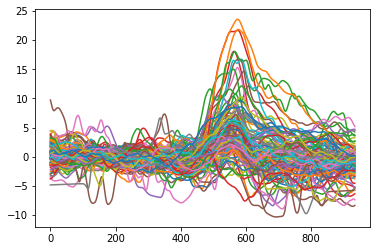

In [3]:
datadir = 'C:\\Users\\lloydb\\surfdrive\\ExperimentData\\PEEG_TVNS\\raw_data\\tobii_data'    # change this path 
subjects=glob.glob(os.path.join(datadir, 'PEEG*'))
excl = ['003','004','005', '021','022', '023', '002', '001', '028', '018']
#excl = ['003','004','028', '018']
subjectlist = []
for c_sub, n_sub in enumerate(subjects):
    subjectlist.append(os.path.split(subjects[c_sub])[1][-3:])

subjectlist_fin = [x for x in subjectlist if x not in excl]
print('Number of participants ready to be processed: {}'.format(len(subjectlist_fin)))

sF=40

#=== Start processing the data: 

# make pd dataframe for extra info
col_names = ['sub', 'Pupil baseline (-10 s)_stim', 'Pupil baseline (-10 s)_sham', 'BF window_stim', 'BF window_sham', 
             'Trials remaining_stim', 'Trials remaining_sham', 
            'GazeX_stim', 'GazeX_sham', 'GazeY_stim', 'GazeY_sham', 'Blink rate_stim', 'Blink rate_sham', 'block1_BL', 'block2_BL', 'block3_BL', 'block4_BL', 'age', 'Intensity_stim', 'Intensity_sham', 
            'Headache_stim', 'Nauseous_stim', 'Dizziness_stim', 'Neck pain_stim', 'Neck muscle contractions_stim',
            'Stinging ear_stim', 'Skin irritation_stim', 'Concentration_stim', 'Unpleasant feelings_stim', 'Good mood_stim',
            'Alert_stim', 'Headache_sham', 'Nauseous_sham', 'Dizziness_sham', 'Neck pain_sham', 'Neck muscle contractions_sham',
            'Stinging ear_sham', 'Skin irritation_sham', 'Concentration_sham', 'Unpleasant feelings_sham', 'Good mood_sham',
            'Alert_sham']
df = pd.DataFrame(columns = col_names)
trial_Dat = pd.DataFrame(columns = ['sub','Pupil baseline (-1 s)_stim', 'Pupil baseline (-1 s)_sham', 'Pupil halfMax response_stim', 'Pupil halfMax response_sham'])
all_trial_Dat = trial_Dat

# prep group lists
pup_tot_stim_pd = pd.DataFrame(columns = subjectlist_fin)
pup_tot_sham_pd = pd.DataFrame(columns = subjectlist_fin)
pup_tot_stim = []
pup_tot_sham = []

# process subjs 
for sub in subjectlist_fin:
    # run class
    pup_stim, pup_sham, info_dat,trial_by_trial_dat = prepPupil(sub).process()
    
    # append information variables to df
    df.loc[len(df.index)] = info_dat    
    
    #append trial by trial data
    trial_Dat['Pupil baseline (-1 s)_stim'] = trial_by_trial_dat[0].tolist()
    trial_Dat['Pupil baseline (-1 s)_sham'] = trial_by_trial_dat[1].tolist()
    trial_Dat['Pupil halfMax response_stim'] = trial_by_trial_dat[2].tolist()
    trial_Dat['Pupil halfMax response_sham'] = trial_by_trial_dat[3].tolist()
    trial_Dat['sub'] = [sub]*len(trial_by_trial_dat[0])
    all_trial_Dat = pd.concat([all_trial_Dat, trial_Dat], axis=0)
    trial_Dat = pd.DataFrame(columns = ['sub','Pupil baseline (-1 s)_stim', 'Pupil baseline (-1 s)_sham', 'Pupil halfMax response_stim', 'Pupil halfMax response_sham'])
    
    # append pupil timecourses for plotting/analysis
    pup_tot_stim.append(pup_stim)
    pup_tot_sham.append(pup_sham)
    
    # append to pandas dataframe for saving as .csv!
    pup_tot_stim_pd[sub] = pup_stim
    pup_tot_sham_pd[sub] = pup_sham




In [4]:
# Define the order column
tvns_then_sham = ['007', '011', '013', '015', '017', '024', '025', '027', '029', '031', '033', '035', '037', '039']

sham_then_tvns = ['006', '008', '009', '010', '012', '014', '016', '019', '020', '026', '030', '032', '034', '036', '038']

print(f'{len(tvns_then_sham)} people underwent order: tvns > sham')
print(f'{len(sham_then_tvns)} people underwent order: sham > tvns')

# Create a new order column with default values of 0
df['Order'] = 0

# Set the values to 1 for the specified rows
df.loc[df['sub'].isin(tvns_then_sham), 'Order'] = 1

14 people underwent order: tvns > sham
15 people underwent order: sham > tvns


In [5]:
# check number of responsers vs non-responders (pupil only)
total_rows = df.shape[0]

# Calculate the number of rows where column 1 is greater than column 2
pos_effect = (df['BF window_stim'] > df['BF window_sham']).sum()

# Calculate the number of rows where column 2 is greater than column 1
neg_effect = (df['BF window_sham'] > df['BF window_stim']).sum()

# Calculate the percentage where column 1 is greater than column 2
percentage_pos_effect = (pos_effect / total_rows) * 100

# Calculate the percentage where column 2 is greater than column 1
percentage_neg_effect = (neg_effect / total_rows) * 100

# Print the results
print("Percentage where stim greater than sham: {:.2f}%".format(percentage_pos_effect))
print("Percentage where sham greater than stim: {:.2f}%".format(percentage_neg_effect))

Percentage where stim greater than sham: 75.86%
Percentage where sham greater than stim: 24.14%


C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


p-value for t-test between stim / sham for BF window is 0.008608592469900115


C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


p-value for t-test between stim / sham for Pupil baseline (-10 s) is 0.5850270925103997


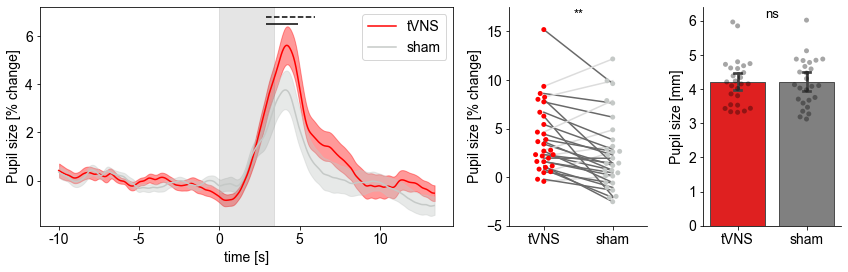

Max % change for stim is 5.62% +/- 1.58%, occuring at 4.2s [Sharon: 4.05% +- 0.92% at 4.25s]
Inreasing to half maximum stim at 2.7s, decreasing to half maximum at 5.35s [Sharon: 2.53s and 8.17s]
Max % change for sham is 3.77% +/- 1.61%, occuring at 4.1s [Sharon: 1.67% +- 0.63% at 4.25s]
Inreasing to half maximum sham at 2.67s, decreasing to half maximum at 5.2s [Sharon: no report]
Sig difference between tVNS/sham starting from 2.88s and ending at 4.9s [Sharon: 2.88 to 5.96 s,]


In [37]:
# # plots settings:
# #---------------------------------------

start_window = 10
end_window = 13.4
sF = 40
x = np.array(range(1,int((end_window--start_window)*sF)+1))

# make Figure 3.  (box plot and density plot made in JASP)
# settings ----------
# make pallette for line plot 
plat= ['#696969']*len(subjectlist_fin)
for  i, (stim,sham) in enumerate(zip(df['BF window_stim'], df['BF window_sham'])):
    if sham > stim: 
        plat[i]='#DCDCDC'

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [3,1,1]}, figsize=(12,4))
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.5, 
                    hspace=0.8)
df_stack['id'] = df_stack['id'].astype(float)
df_stack['val'] = df_stack['val'].astype(float)


agg_stim_mean = np.mean(pup_tot_stim[:],axis=0)
agg_stim_SEM = scipy.stats.sem(pup_tot_stim[:], axis=0, nan_policy= 'omit')
agg_stim_SEM1 = agg_stim_mean - agg_stim_SEM 
agg_stim_SEM2 = agg_stim_mean + agg_stim_SEM

# sham 
agg_sham_mean = np.mean(pup_tot_sham[:],axis=0)
agg_sham_SEM = scipy.stats.sem(pup_tot_sham[:], axis=0, nan_policy= 'omit')
agg_sham_SEM1 = agg_sham_mean - agg_sham_SEM 
agg_sham_SEM2 = agg_sham_mean + agg_sham_SEM
#---------------------------------------
xticks = np.arange(0, len(pup_tot_stim[0]), sF*5).tolist(),np.arange(-start_window, 15,5).tolist()

# Statistical test: point-wise two-sided t-test
stat, p_val_uncor = st.permtest_rel(pup_tot_stim[:], pup_tot_sham[:], axis=0)
p_val_cor=sm.stats.fdrcorrection(p_val_uncor, alpha=0.05)
sig_point=np.where(p_val_cor[0]==True)
#patch = patches.Patch(color='grey', label='Manual Label')
#plot timeseries 
axs[0].plot(agg_stim_mean, label='tVNS', color =  "#FF0000") 
axs[0].plot(agg_sham_mean, label='sham',color =  "#C5C9C7") 
axs[0].fill_between(x, agg_stim_SEM1,agg_stim_SEM2, alpha = 0.4,color =  "#FF0000") 
axs[0].fill_between(x, agg_sham_SEM1,agg_sham_SEM2, alpha = 0.4,color =  "#C5C9C7") 
axs[0].set_xticks(xticks[0])
axs[0].set_xticklabels(xticks[1])
axs[0].legend()
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("Pupil size [% change]")
axs[0].hlines(y=6.8,xmin = round(12.88*40), xmax = round(15.96*40), linestyles = 'dashed') # sharon sig line
axs[0].hlines(y=6.5,xmin = sig_point[0][0], xmax = sig_point[0][-1]) # sig line
axs[0].add_patch(Rectangle((start_window*sF, -2), 136, 10,color="grey", alpha=0.2))
#axs[0].text(-3.55, 5.05, string.ascii_uppercase[0], transform=ax.transAxes, 
 #               size=20, weight='normal')
#axs[0].legend(handles=[patch])
#-6.11, 1.148
feelings_tot = ['BF window','Pupil baseline (-10 s)']
y_axes_labels = ['Pupil size [% change]', 'Pupil size [mm]']

for n, (f,y,ax) in enumerate(zip(feelings_tot, y_axes_labels, axs[1:].ravel())):
    
    feeling = [f'{f}_stim', f'{f}_sham']
    feeling_df = df_stack[df_stack['condition'].isin(feeling)]
    feeling_df_fin = feeling_df.loc[feeling_df['val'] != 'NaN']  
    
    if f == 'Pupil baseline (-10 s)':  # 3 people dropped from baseline comparison! 
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 5]
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 17]
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 21]
    
    # perform statistics (paired t-test)
    stat, pvalue = scipy.stats.wilcoxon(
    feeling_df_fin[feeling_df_fin['condition']==f'{f}_stim']['val'],
    feeling_df_fin[feeling_df_fin['condition']==f'{f}_sham']['val']
    )
    print(f'p-value for t-test between stim / sham for {f} is {pvalue}')
    # convert p-val to asterisks
    sig_lev = convert_pvalue_to_asterisks(pvalue)

    f'{f}_stim'
    my_pal = {f'{f}_stim': "#FF0000", f'{f}_sham': "#C5C9C7"}
    # plot bar plots
    if f == 'Pupil baseline (-10 s)':
        sns.barplot(ax=ax,x="condition", y="val", data=feeling_df_fin, capsize=.1, edgecolor=".3",palette=['red', 'grey'])
        sns.swarmplot(ax=ax,x="condition", y="val", data=feeling_df_fin, color="0",  alpha=.35)
        
    if f == 'BF window':
        sns.swarmplot(ax=ax,x="condition", y="val", data=feeling_df_fin, palette=my_pal)
        sns.lineplot(ax=ax,x="condition", y="val", hue = "id",  data=feeling_df_fin, sort=False, palette=plat)
        ax.get_legend().remove()
        ax.set_ylim(-5, 17.5)
    # add sig level to plot
    ax.text(0.5,0.99,sig_lev,horizontalalignment='center',
     verticalalignment='top', transform = ax.transAxes,  fontsize = 13)
    
    #ax.set_ylim([min(feeling_df_fin['val']), max(feeling_df_fin['val'])+1])
    #ax.set_title(f)
    ax.set(xticklabels=['tVNS', 'sham']) 
    ax.set(xlabel=None, ylabel=y)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.text(-0.1, 1.1, string.ascii_uppercase[n+1], transform=ax.transAxes, 
                #size=20, weight='normal')
    
    
plt.tight_layout()
plt.show()
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/Fig3.pdf',dpi=300) 



#---------------------------------------
# calculate full half/full peaks of timeseries
peaks_stim, _ = find_peaks(agg_stim_mean)
results_half_stim = peak_widths(agg_stim_mean, peaks_stim, rel_height=0.5)
results_half_stim[0]  # widths
results_full_stim = peak_widths(agg_stim_mean, peaks_stim, rel_height=1)
results_full_stim[0]  # widths

peaks_sham, _ = find_peaks(agg_sham_mean)
results_half_sham = peak_widths(agg_sham_mean, peaks_sham, rel_height=0.5)
results_half_sham[0]  # widths
results_full_sham = peak_widths(agg_sham_mean, peaks_sham, rel_height=1)
results_full_sham[0]  # widths

# make long dataframe
df_stack = df.stack().reset_index()
df_stack.columns = ['id', 'condition', 'val']

max_stim = round(max(agg_stim_mean),2)
SE_stim = round(abs((max(agg_stim_mean)- max(agg_stim_SEM2))) + (max(agg_stim_mean)- max(agg_stim_SEM1)),2)
max_time_stim = round(np.argmax(agg_stim_mean, axis=0)/40-10, 2)
half_maximum_up_stim = round(results_half_stim[2][6]/40-10,2)
half_maximum_down_stim = round(results_half_stim[3][6]/40-10,2)
print(f'Max % change for stim is {max_stim}% +/- {SE_stim}%, occuring at {max_time_stim}s [Sharon: 4.05% +- 0.92% at 4.25s]')
print(f'Inreasing to half maximum stim at {half_maximum_up_stim}s, decreasing to half maximum at {half_maximum_down_stim}s [Sharon: 2.53s and 8.17s]')


max_sham = round(max(agg_sham_mean),2)
SE_sham = round(abs((max(agg_sham_mean)- max(agg_sham_SEM2))) + (max(agg_sham_mean)- max(agg_sham_SEM1)),2)
max_time_sham = round(np.argmax(agg_sham_mean, axis=0)/40-10, 2)
half_maximum_up_sham = round(results_half_sham[2][8]/40-10,2)
half_maximum_down_sham = round(results_half_sham[3][8]/40-10,2)
print(f'Max % change for sham is {max_sham}% +/- {SE_sham}%, occuring at {max_time_sham}s [Sharon: 1.67% +- 0.63% at 4.25s]')
print(f'Inreasing to half maximum sham at {half_maximum_up_sham}s, decreasing to half maximum at {half_maximum_down_sham}s [Sharon: no report]')

start_sig = round((sig_point[0][0]/40)-10, 2)
end_sig = round((sig_point[0][-2]/40)-10, 2)
print(f'Sig difference between tVNS/sham starting from {start_sig}s and ending at {end_sig}s [Sharon: 2.88 to 5.96 s,]')


p-val for analysis on BF window  is 0.009
p-val for analysis on Pupil baseline (-10 s)  is 0.585


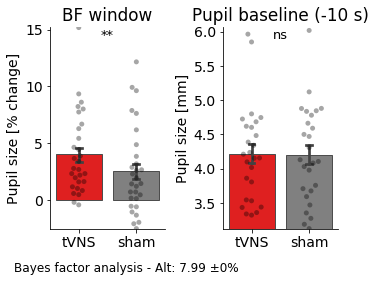

In [13]:
# plot bar plots for peak pupil size (sharon window) and baseline. --> NOTE: final Figure 2. with lines between conditions and subplots is at end of script! 

#fig, axs = plt.subplots(1, 2, figsize=(6,4))
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,1]}, figsize=(5,4))
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.5, 
                    hspace=0.8)
fig.text(0, -0.05, 'Bayes factor analysis - Alt: 7.99 ±0%', fontsize = 12)

feelings_tot = ['BF window','Pupil baseline (-10 s)']
y_axes_labels = ['Pupil size [% change]', 'Pupil size [mm]']

for f,y,ax in zip(feelings_tot, y_axes_labels, axs.ravel()):
    feeling = [f'{f}_stim', f'{f}_sham']
    feeling_df = df_stack[df_stack['condition'].isin(feeling)]
    feeling_df_fin = feeling_df.loc[feeling_df['val'] != 'NaN']  
    
    if f == 'Pupil baseline (-10 s)':  # 3 people dropped from baseline comparison! 
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 5]
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 17]
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 21]
    
    # perform statistics (paired t-test)
    stat, pvalue = scipy.stats.wilcoxon(
    feeling_df_fin[feeling_df_fin['condition']==f'{f}_stim']['val'],
    feeling_df_fin[feeling_df_fin['condition']==f'{f}_sham']['val']
    )
    # convert p-val to asterisks
    sig_lev = convert_pvalue_to_asterisks(pvalue)
    print(f'p-val for analysis on {f}  is {round(pvalue,3)}')
    # plot bar plots
    sns.barplot(ax=ax,x="condition", y="val", data=feeling_df_fin, capsize=.1, edgecolor=".3",ci=68,palette=['red', 'grey'])
    sns.swarmplot(ax=ax,x="condition", y="val", data=feeling_df_fin, color="0", alpha=.35)
    
    # add sig level to plot
    ax.text(0.5,0.99,sig_lev,horizontalalignment='center',
     verticalalignment='top', transform = ax.transAxes,  fontsize = 13)
    
    ax.set_ylim([min(feeling_df_fin['val']), max(feeling_df_fin['val'])+0.05])
    ax.set_title(f)
    ax.set(xticklabels=['tVNS', 'sham']) 
    ax.set(xlabel=None, ylabel=y)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


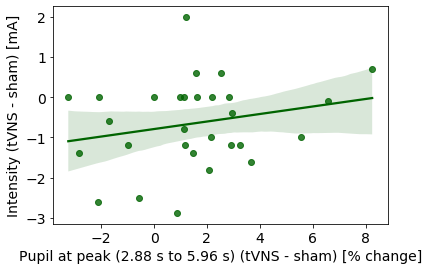

No correlation for effect (tvns - sham) between intensity and peak response [r=0.18, p=0.353]


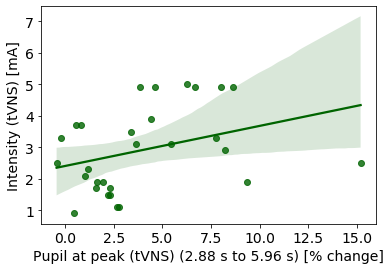

Positive correlation for tvns between intensity and peak response [r=0.39, p=0.035]


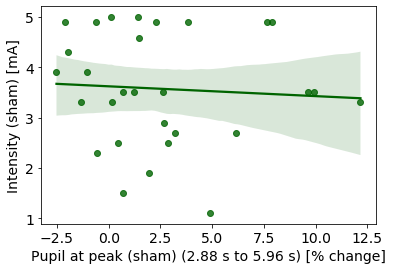

No correlation for sham between intensity and peak response [r=-0.15, p=0.444]


In [14]:
# Correlate the intensity with effect of stimulation

# calc difference scores for pupil peak:
df['Difference_pupil_peak'] = df['BF window_stim']-df['BF window_sham']
# calc difference scores for intensity:
df['Difference_intensity'] = df['Intensity_stim']-df['Intensity_sham']


ax = sns.regplot(x='Difference_pupil_peak', y='Difference_intensity', data=df, color = 'darkgreen')
ax.set(xlabel='Pupil at peak (2.88 s to 5.96 s) (tVNS - sham) [% change]', ylabel='Intensity (tVNS - sham) [mA]')
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/Fig2D.jpg',dpi=300) 
plt.show()

r, pval = stats.spearmanr(df['Difference_intensity'], df['Difference_pupil_peak'])

print(f'No correlation for effect (tvns - sham) between intensity and peak response [r={round(r,2)}, p={round(pval,3)}]')


ax = sns.regplot(x='BF window_stim', y='Intensity_stim', data=df, color = 'darkgreen')
ax.set(xlabel='Pupil at peak (tVNS) (2.88 s to 5.96 s) [% change]', ylabel='Intensity (tVNS) [mA]')
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/Fig2D.jpg',dpi=300) 
plt.show()

r1, pval1 = stats.spearmanr(df['Intensity_stim'], df['BF window_stim'])
print(f'Positive correlation for tvns between intensity and peak response [r={round(r1,2)}, p={round(pval1,3)}]')


ax = sns.regplot(x='BF window_sham', y='Intensity_sham', data=df, color = 'darkgreen')
ax.set(xlabel='Pupil at peak (sham) (2.88 s to 5.96 s) [% change]', ylabel='Intensity (sham) [mA]')
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/Fig2D.jpg',dpi=300) 
plt.show()

r2, pval2 = stats.spearmanr(df['Intensity_sham'], df['BF window_sham'])
print(f'No correlation for sham between intensity and peak response [r={round(r2,2)}, p={round(pval2,3)}]')


In [15]:
# Reviewer #1: check if the above correlations are significantly different using permutation test

y_stim = df['Intensity_stim']
x_stim = df['BF window_stim']
y_sham = df['Intensity_sham']
x_sham = df['BF window_sham']

# Calculate the observed correlation coefficients
r_obs_stim, pval_obs_stim = stats.spearmanr(x_stim, y_stim)
r_obs_sham, pval_obs_sham = stats.spearmanr(x_sham, y_sham)

# Set the number of permutations
num_permutations = 1000

# Create an array to store the permuted correlation coefficients
permuted_correlations = np.zeros(num_permutations)

# Perform the permutation test
for i in range(num_permutations):
    # Permute the values of the first variable
    x_stim_permuted = np.random.permutation(x_stim)
    
    # Calculate the correlation coefficient with the permuted variable
    r_stim_permuted, pval_stim_permuted = stats.spearmanr(x_stim_permuted, y_stim)
    
    # Calculate the difference between permuted and observed correlations
    diff_stim = abs(r_stim_permuted - r_obs_stim)
    
    # Permute the values of the second variable
    x_sham_permuted = np.random.permutation(x_sham)
    
    # Calculate the correlation coefficient with the permuted variable
    r_sham_permuted, pval_sham_permuted = stats.spearmanr(x_sham_permuted, y_sham)
    
    # Calculate the difference between permuted and observed correlations
    diff_sham = abs(r_sham_permuted - r_obs_sham)
    
    # Store the maximum difference
    permuted_correlations[i] = max(diff_stim, diff_sham)

# Calculate the p-value based on the permutation test
p_value = (np.sum(permuted_correlations >= max(abs(r_obs_stim - r_obs_sham), abs(r_obs_sham - r_obs_stim))) + 1) / (num_permutations + 1)
print(p_value)
# Check if the p-value is below a significance threshold (e.g., 0.05)
if p_value < 0.05:
    print("The two correlations are statistically different.")
else:
    print("The two correlations are not statistically different.")

0.21878121878121878
The two correlations are not statistically different.


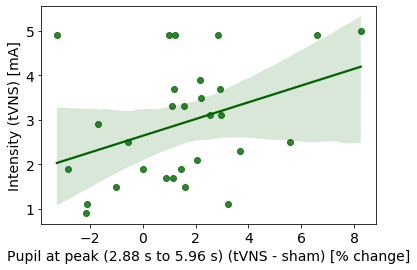

No correlation for tvns between intensity and peak response [r=0.35, p=0.064]


In [17]:
# Reviewer request: calc difference scores for intensity for tvns only:
df['Difference_pupil_peak'] = df['BF window_stim']-df['BF window_sham']

ax = sns.regplot(x='Difference_pupil_peak', y='Intensity_stim', data=df, color = 'darkgreen')
ax.set(xlabel='Pupil at peak (2.88 s to 5.96 s) (tVNS - sham) [% change]', ylabel='Intensity (tVNS) [mA]')
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/tVNS_intensity_x_peak_pupil_difference.jpg',dpi=300) 
plt.show()

r, pval = stats.spearmanr(df['Intensity_stim'], df['Difference_pupil_peak'])

print(f'No correlation for tvns between intensity and peak response [r={round(r,2)}, p={round(pval,3)}]')

In [38]:
## Reviewer: asked about baseline pupil * peak pupil correlation
id_vars = ['sub'] 
value_vars_BL = ['Pupil baseline (-1 s)_stim', 'Pupil baseline (-1 s)_sham']
long_df_BL = pd.melt(all_trial_Dat, id_vars=id_vars, value_vars=value_vars_BL, var_name='Variable', value_name='Pupil baseline')
long_df_BL.drop('Variable', axis=1, inplace=True)
value_vars_resp = ['Pupil halfMax response_stim', 'Pupil halfMax response_sham']
long_df_resp = pd.melt(all_trial_Dat, id_vars=id_vars, value_vars=value_vars_resp, var_name='Variable', value_name='Pupil response')
long_df_resp.drop('Variable', axis=1, inplace=True)
trial_dat_merge = long_df_BL.merge(long_df_resp, on='sub',how='left')
long_df_resp['Pupil baseline'] = long_df_BL['Pupil baseline']

Average R value for all subjects: -0.10
T-statistic for both conditions (averaged): -2.916288743450974
p-val for both conditions (averaged): 0.0069025064082707845


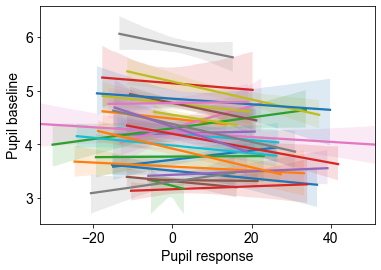

In [40]:
# Look into basline * peak averaged across both conditions: 
from scipy.stats import ttest_1samp

# Initialize an empty list to store regression line plots
reg_plots = []
r_values = []

# Loop over each unique value of 'sub'
for sub_value in long_df_resp['sub'].unique():
    # Filter the DataFrame for the current 'sub' value
    sub_df = long_df_resp[long_df_resp['sub'] == sub_value]
    
    # Calculate the correlation between 'response' and 'baseline'
    r, pval = stats.spearmanr(sub_df['Pupil response'], sub_df['Pupil baseline'],nan_policy='omit')
    # Append the correlation value to the list
    r_values.append(r)
    
    # Plot the regression line
    reg_plot = sns.regplot(x='Pupil response', y='Pupil baseline', data=sub_df, scatter=False)
    reg_plots.append(reg_plot)

# Calculate the average R value
average_r = sum(r_values) / len(r_values)
print(f"Average R value for all subjects: {average_r:.2f}")

# fischer transform the R values and run 1-sided test
z_scores = fisher_transform(r_values)
z_scores
# Perform one-sided t-test against 0
t_statistic, p_value = ttest_1samp(z_scores, popmean=0)

# Print the t-statistic and p-value
print("T-statistic for both conditions (averaged):", t_statistic)
print("p-val for both conditions (averaged):", p_value)

In [43]:
# tVNS condition only:
stim_data = all_trial_Dat[['sub','Pupil baseline (-1 s)_stim', 'Pupil halfMax response_stim']]
stim_data
r_values = []

# Loop over each unique value of 'sub'
for sub_value in stim_data['sub'].unique():
    # Filter the DataFrame for the current 'sub' value
    sub_df = stim_data[stim_data['sub'] == sub_value]
    # Calculate the correlation between 'response' and 'baseline'
    r, pval = stats.spearmanr(sub_df['Pupil halfMax response_stim'], sub_df['Pupil baseline (-1 s)_stim'],nan_policy='omit')
    # Append the correlation value to the list
    r_values.append(r)

# Calculate the average R value
average_r = sum(r_values) / len(r_values)
print(f"tVNS: Average R value for all subjects: {average_r:.2f}")

# Can't handle the -1 value = making is -0.99
r_values = [-0.99 if value == -1.0 else value for value in r_values]

# fischer transform the R values and run 1-sided test
stim_z_scores = fisher_transform(r_values)

# Perform one-sided t-test against 0
t_statistic, p_value = ttest_1samp(stim_z_scores, popmean=0,nan_policy='omit')

# Print the t-statistic and p-value
print("tVNS: T-statistic:", t_statistic)
print("tVNS: p-val:", p_value)

tVNS: Average R value for all subjects: -0.17
tVNS: T-statistic: -2.516292392847958
tVNS: p-val: 0.017868924191263427


In [44]:
sham_data = all_trial_Dat[['sub','Pupil baseline (-1 s)_sham', 'Pupil halfMax response_sham']]
r_values = []
# Loop over each unique value of 'sub'
for sub_value in sham_data['sub'].unique():
    # Filter the DataFrame for the current 'sub' value
    sub_df = sham_data[sham_data['sub'] == sub_value]
    
    # Calculate the correlation between 'response' and 'baseline'
    r, pval = stats.spearmanr(sub_df['Pupil halfMax response_sham'], sub_df['Pupil baseline (-1 s)_sham'],nan_policy='omit')
    # Append the correlation value to the list
    r_values.append(r)
# Calculate the average R value
average_r = sum(r_values) / len(r_values)
print(f"sham: Average R value for all subjects: {average_r:.2f}")
# fischer transform the R values and run 1-sided test
sham_z_scores = fisher_transform(r_values)

# Perform one-sided t-test against 0
t_statistic, p_value = ttest_1samp(sham_z_scores, popmean=0)

# Print the t-statistic and p-value
print("sham: T-statistic:", t_statistic)
print("sham: p-val:", p_value)

sham: Average R value for all subjects: -0.06
sham: T-statistic: -1.194611050092
sham: p-val: 0.24226064905939526


## Load in Average alpha data

In [18]:
# Looking into the link between intensity of stimulation and alpha !
alpha_intensity_path = 'C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/processed_data/other_data'   # change path
df_alph = pd.read_csv(f'{alpha_intensity_path}/eeg_alpha_stim_intensity.csv', sep=';')
df_alph.rename(columns={'subject': 'sub'}, inplace=True)

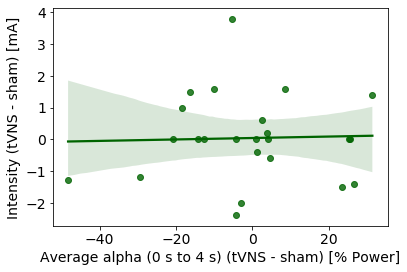

No correlation for effect (tvns - sham) between intensity and average alpha [r=-0.04, p=0.856]


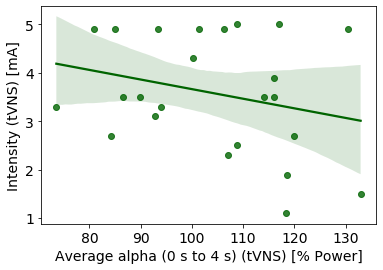

No correlation for tvns between intensity and average alpha [r=-0.21, p=0.334]


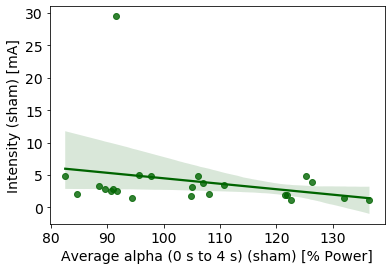

No correlation for sham between intensity and average alpha [r=-0.3, p=0.152]


In [19]:
# Correlate the intensity with effect of stimulation  
# calc difference scores for alpha:
df_alph['Difference_ave_alpha'] = df_alph['tvns']-df_alph['sham']
# calc difference scores for intensity:
df_alph['Difference_intensity'] = df_alph['Intensity_stim']-df['Intensity_sham']

ax = sns.regplot(x='Difference_ave_alpha', y='Difference_intensity', data=df_alph, color = 'darkgreen')
ax.set(xlabel='Average alpha (0 s to 4 s) (tVNS - sham) [% Power]', ylabel='Intensity (tVNS - sham) [mA]')
plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/EEG_diff_alpha_x_intensity.jpg',dpi=300) 
plt.show()

r, pval = stats.spearmanr(df_alph['Difference_intensity'], df_alph['Difference_ave_alpha'])

print(f'No correlation for effect (tvns - sham) between intensity and average alpha [r={round(r,2)}, p={round(pval,3)}]')


ax = sns.regplot(x='tvns', y='Intensity_stim', data=df_alph, color = 'darkgreen')
ax.set(xlabel='Average alpha (0 s to 4 s) (tVNS) [% Power]', ylabel='Intensity (tVNS) [mA]')
plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/EEG_stim_alpha_x_intensity.jpg',dpi=300) 
plt.show()

r1, pval1 = stats.spearmanr(df_alph['Intensity_stim'], df_alph['tvns'])
print(f'No correlation for tvns between intensity and average alpha [r={round(r1,2)}, p={round(pval1,3)}]')


ax = sns.regplot(x='sham', y='Intensity_sham', data=df_alph, color = 'darkgreen')
ax.set(xlabel='Average alpha (0 s to 4 s) (sham) [% Power]', ylabel='Intensity (sham) [mA]')
plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/EEG_sham_alpha_x_intensity.jpg',dpi=300) 
plt.show()

r2, pval2 = stats.spearmanr(df_alph['Intensity_sham'], df_alph['sham'])
print(f'No correlation for sham between intensity and average alpha [r={round(r2,2)}, p={round(pval2,3)}]')

In [20]:
# join the alpha scores to the overall dataframe based on sub
df_to_merge = df
df_to_merge['sub'] = df_to_merge['sub'].astype(str).str.lstrip('0')
df_to_merge['sub'] = df_to_merge['sub'].astype(df_alph['sub'].dtype)
merged_df = pd.merge(df_to_merge, df_alph, on='sub')


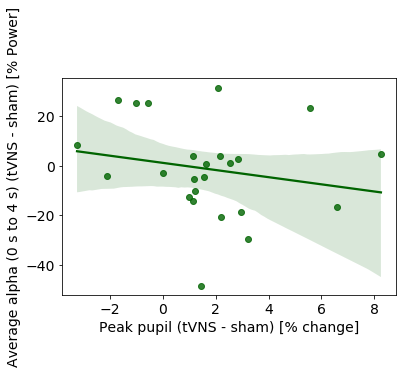

No correlation between the effects (taVNS - sham) on pupil and alpha [r=-0.26, p=0.214]


In [21]:
# After revision: check for correlation of effect (tvns - sham) between pupil and alpha
# calc difference scores for pupil peak:
merged_df['Difference_ave_alpha'] = merged_df['tvns']-merged_df['sham']
# calc difference scores for intensity:
merged_df['Difference_pupil_resp'] = merged_df['BF window_stim']-merged_df['BF window_sham']


ax = sns.regplot(x='Difference_pupil_resp', y='Difference_ave_alpha', data=merged_df, color = 'darkgreen')
ax.set(ylabel='Average alpha (0 s to 4 s) (tVNS - sham) [% Power]', xlabel='Peak pupil (tVNS - sham) [% change]')
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/EEG_diff_alpha_x_pup_diff.pdf',dpi=300) 
plt.show()

r, pval = stats.spearmanr(merged_df['Difference_pupil_resp'], merged_df['Difference_ave_alpha'])

print(f'No correlation between the effects (taVNS - sham) on pupil and alpha [r={round(r,2)}, p={round(pval,3)}]')

In [53]:
# Reviewer asked about whether Sex plays a role in the effect?
# add sex based on pp list
merged_df['sex'] = 'F' 
males = [16, 17, 20, 27, 32, 39]
merged_df.loc[merged_df['sub'].isin(males), 'sex'] = 'M'


# Creating a new DataFrame in long format for 'eeg alpha'
columns_to_select = ['sub', 'BF window_stim', 'BF window_sham', 'sham', 'tvns', 'sex']
sex_df = merged_df[columns_to_select]
alpha_df = pd.melt(
    sex_df,
    id_vars=['sub', 'sex'],
    value_vars=['sham', 'tvns'],
    var_name='condition',
    value_name='alpha'
)

# Creating a new DataFrame in long format for 'pupil size'
pupil_size_df = pd.melt(
    sex_df,
    id_vars=['sub', 'sex'],
    value_vars=['BF window_sham', 'BF window_stim'],
    var_name='condition',
    value_name='pupil size'
)
pupil_size_df['condition'] = pupil_size_df['condition'].replace({'BF window_stim': 'tvns', 'BF window_sham': 'sham'})
pupil_size_df

,sub,sex,condition,pupil size
0,6,F,sham,6.172555
1,7,F,sham,0.703682
2,8,F,sham,0.118639
3,9,F,sham,-1.340698
4,10,F,sham,1.201713
5,11,F,sham,3.177490
6,13,F,sham,-0.553314
7,14,F,sham,0.450845
8,15,F,sham,0.700155
9,16,M,sham,4.870095


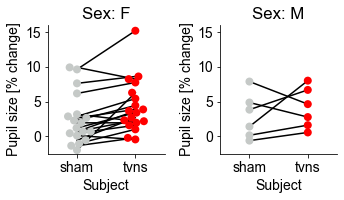

In [63]:
# Creating pupil size figure based on sex: PUPIL
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
my_pal = [ "#C5C9C7", "#FF0000"]

grouped_df = pupil_size_df.groupby('sex')


# Iterating over the grouped DataFrame and plotting the subplots
for i, (sex, data) in enumerate(grouped_df):
    ax = axes[i]  # Selecting the appropriate subplot
    palette = sns.color_palette(['black'], len(data['sub'].unique()))
    sns.swarmplot(ax=ax,x="condition", y="pupil size", data=data, palette = my_pal, size=8)
    sns.lineplot(ax=ax,x="condition", y="pupil size", hue = 'sub', data=data,  palette =palette)
    
    # Setting subplot title and labels
    ax.set_title(f'Sex: {sex}')
    ax.set_xlabel('Subject')
    ax.set_ylabel('Pupil size [% change]')
    ax.get_legend().remove()
    ax.set_ylim(-2.5, 16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
# Adjusting the layout and displaying the plot
plt.tight_layout()
plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/male_female_pupil.pdf',dpi=300) 
plt.show()

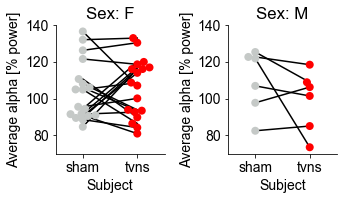

In [64]:
# Creating alpha figure based on sex: ALPHA
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
my_pal = [ "#C5C9C7", "#FF0000"]

grouped_df = alpha_df.groupby('sex')

# Iterating over the grouped DataFrame and plotting the subplots
for i, (sex, data) in enumerate(grouped_df):
    ax = axes[i]  # Selecting the appropriate subplot
    palette = sns.color_palette(['black'], len(data['sub'].unique()))
    sns.swarmplot(ax=ax,x="condition", y="alpha", data=data, palette = my_pal, size=8)
    sns.lineplot(ax=ax,x="condition", y="alpha", hue = 'sub', data=data,  palette =palette)
    
    # Setting subplot title and labels
    ax.set_title(f'Sex: {sex}')
    ax.set_xlabel('Subject')
    ax.set_ylabel('Average alpha [% power]')
    ax.get_legend().remove()
    ax.set_ylim(70, 140)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
# Adjusting the layout and displaying the plot
plt.tight_layout()
plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/male_female_alpha.pdf',dpi=300) 
plt.show()

### Plot additional variables between conditions 

C:\Users\lloydb\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<function matplotlib.pyplot.show(*args, **kw)>

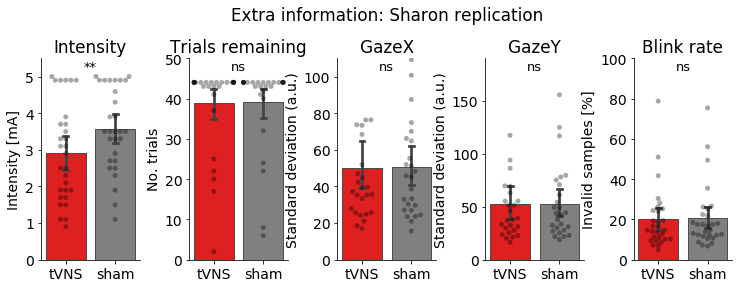

In [24]:
  # plot bar plots
fig, axs = plt.subplots(1, 5, figsize=(12,4))
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.5, 
                    hspace=0.4)
fig.suptitle('Extra information: Sharon replication')

feelings_tot = ['Intensity','Trials remaining', 'GazeX', 'GazeY', 'Blink rate']
y_axes_labels = ['Intensity [mA]', 'No. trials', 'Standard deviation (a.u.)', 'Standard deviation (a.u.)', 'Invalid samples [%]']

y_ax_lim = [5.5, 50, 110, 190, 100]

total_pvalue = []
for f,y,ylim,ax in zip(feelings_tot, y_axes_labels, y_ax_lim, axs.ravel()):
    # extract each variable
    feeling = [f'{f}_stim', f'{f}_sham']
    feeling_df = df_stack[df_stack['condition'].isin(feeling)]
    feeling_df_fin = feeling_df.loc[feeling_df['val'] != 'NaN']
    
    if (f == 'GazeX') or (f == 'GazeY'):  # 3 people dropped from gazex comparison! 
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 5]
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 17]
        feeling_df_fin = feeling_df_fin[feeling_df_fin.id != 21]
    
     # perform statistics (paired t-test) --> need to fdr correct this!
    stat, pvalue = scipy.stats.wilcoxon(
    feeling_df_fin[feeling_df_fin['condition']==f'{f}_stim']['val'],
    feeling_df_fin[feeling_df_fin['condition']==f'{f}_sham']['val']
    )
    
    sig_lev = convert_pvalue_to_asterisks(pvalue)

    # plot bar plots
    sns.barplot(ax=ax,x="condition", y="val", data=feeling_df_fin, capsize=.1, edgecolor=".3",palette=['red', 'grey'])
    sns.swarmplot(ax=ax,x="condition", y="val", data=feeling_df_fin, color="0", alpha=.35)

    # add sig level to plot
    ax.text(0.5,0.99,sig_lev,horizontalalignment='center',
     verticalalignment='top', transform = ax.transAxes,  fontsize = 13)
    
    # other settings
    ax.set_title(f)
    ax.set(xticklabels=['tVNS', 'sham']) 
    ax.set(xlabel=None, ylabel=y)
    ax.set_ylim(top=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#plt.savefig('C:/Users/lloydb/surfdrive/ExperimentData/PEEG_TVNS/stats/Figures/Fig2C.jpg',dpi=300) 
plt.show
    

### Plot subjective questions

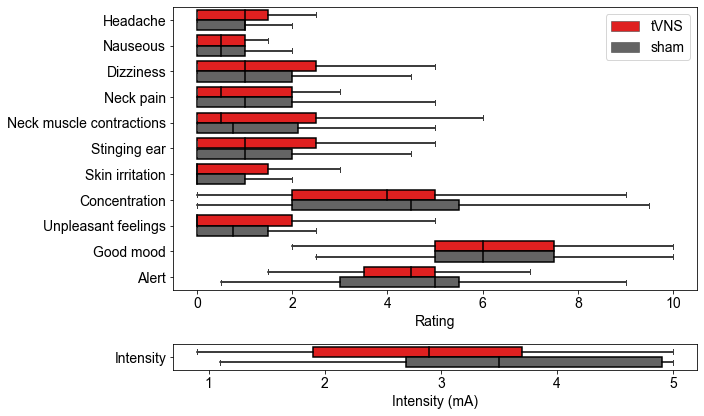

In [25]:
# Settings
feelings_tot = ['Headache', 'Nauseous', 'Dizziness', 'Neck pain', 'Neck muscle contractions', 'Stinging ear', 'Skin irritation', 'Concentration', 'Unpleasant feelings', 'Good mood', 'Alert', 'Intensity']

# Data preparation
df_stack[['feeling', 'stim_condition']] = df_stack.condition.str.split("_", expand=True)
feeling_df = df_stack[df_stack['feeling'].isin(feelings_tot)].iloc[:, 2:]
feeling_df['stim_condition'] = feeling_df['stim_condition'].str.replace('stim', 'tVNS')

# Set font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14

# Make two plots stacked on each other.
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [11,1]}, figsize=(10,6))
fig.subplots_adjust(hspace=0.4, bottom=0.05)

# Define colors for the plot
my_pal = {"tVNS": "#FF0000", "sham": "#646464"}

# Plot all subject questions
feelings_tot_list = ['Headache', 'Nauseous', 'Dizziness', 'Neck pain', 'Neck muscle contractions', 'Stinging ear', 'Skin irritation', 'Concentration', 'Unpleasant feelings', 'Good mood', 'Alert']
feeling_df_list = feeling_df.loc[feeling_df['feeling'].isin(feelings_tot_list)]
sns.boxplot(data=feeling_df_list, x="val", y="feeling", hue="stim_condition", 
            showfliers=False, width=0.8, ax=axs[0], linewidth=1, palette=my_pal, boxprops=dict(edgecolor='black', linewidth=1.5),
            medianprops=dict(color='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5))

axs[0].set_xlabel('Rating', fontname='Arial', fontsize=14)
axs[0].set_ylabel('')
axs[0].legend(title=None)

# Plot intensity
intensity_df = feeling_df.loc[feeling_df['feeling'] == 'Intensity']
sns.boxplot(data=intensity_df, x="val", y="feeling", hue="stim_condition",
            showfliers=False, width=0.8, ax=axs[1], linewidth=1, palette=my_pal, boxprops=dict(edgecolor='black', linewidth=1.5),
            medianprops=dict(color='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5))

axs[1].set_xlabel('Intensity (mA)', fontname='Arial', fontsize=14)
axs[1].set_ylabel('')
axs[1].get_legend().remove()

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)

fig.subplots_adjust(left=0.2)

# Save the figures to file
current_directory = os.getcwd()
for i in range(3):
    current_directory = os.path.abspath(os.path.join(current_directory, os.pardir))

file_path_pdf = os.path.join(current_directory, 'stats', 'Figures', 'Fig2_red_grey.pdf')
file_path_png = os.path.join(current_directory, 'stats', 'Figures', 'Fig2_red_grey.png')
fig.tight_layout()
#fig.savefig(file_path_pdf, dpi=500)
#fig.savefig(file_path_png, dpi=500)